## Purpose of this notebook

When government documents aren't structured PDF, they are often available as PDF (and/or office documents).

PDFs generated from structure data or via office documents 
often has structured text inside you can extract directly,
but a number of PDF documents instead contain images of text.

We care to turn that back into text we can feed to our methods.

<!-- -->

Keep in mind that there are varied products and services out there (e.g. [documentcloud](https://www.documentcloud.org/app), TODO: list more) that help do just this, may be much lower-worry and may scale better,
but which you might avoid when your data is not public, and/or you want more control over the results.

The below is an example of doing it yourself. 
There is a more complex example linked below (right after an example of why you might want that).

<!-- -->

----

This is provided in part as expectation management about 
  ease of use and output quality of modern OCR.

Keep in mind that OCR is not considered core feature, 
  is currently a thin wrapper around something else,
  and is likely to change in the future (e.g. tesseract may be more future-compatible than easyocr).
  Also consider that services like google vision are better-quality, but paid-for and may not be GDPR-compatible, etc. A summary of such details may be useful.



In [1]:
import wetsuite.helpers.net
import wetsuite.datacollect.pdf
import wetsuite.extras.ocr

### Notice we will need this



In [2]:
# fetch a cherry-picked example
pdfbytes = wetsuite.helpers.net.download('https://open.overheid.nl/documenten/ronl-5439f4bf9849a53e634389ebbb5e4f5740c4f84f/pdf')

In [5]:
# extract the text the PDF says it has
chars_per_page, num_pages_with_text, num_pages = wetsuite.datacollect.pdf.count_pages_with_text(pdfbytes, char_threshold=150)

In [7]:
print(f'{num_pages_with_text} out of {num_pages} pages contain reasonable amount of text\n  characters per page: {chars_per_page}')

7 out of 20 pages contain reasonable amount of text
  characters per page: [1477, 2699, 707, 602, 2365, 2582, 399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


...which very much looks like a PDF composed of a response letter as text,
plus the actual requested documents as image (scanned documents).

### PDF to image, image to text

OCR takes images as input, so now we want the PDF as images.

We _could_ skip the pages we alreay have text for and save some processing time,
but it's less code, and potentially a good double-check,
to see what it makes of the pages we do have text for. 

In [5]:
# should take a few seconds -- but keep in mind that for 300-page documents, 
#  not using a generator implies a LOT of RAM use.
page_images = list( wetsuite.datacollect.pdf.pages_as_images(pdfbytes, dpi=200, antialiasing=True) )


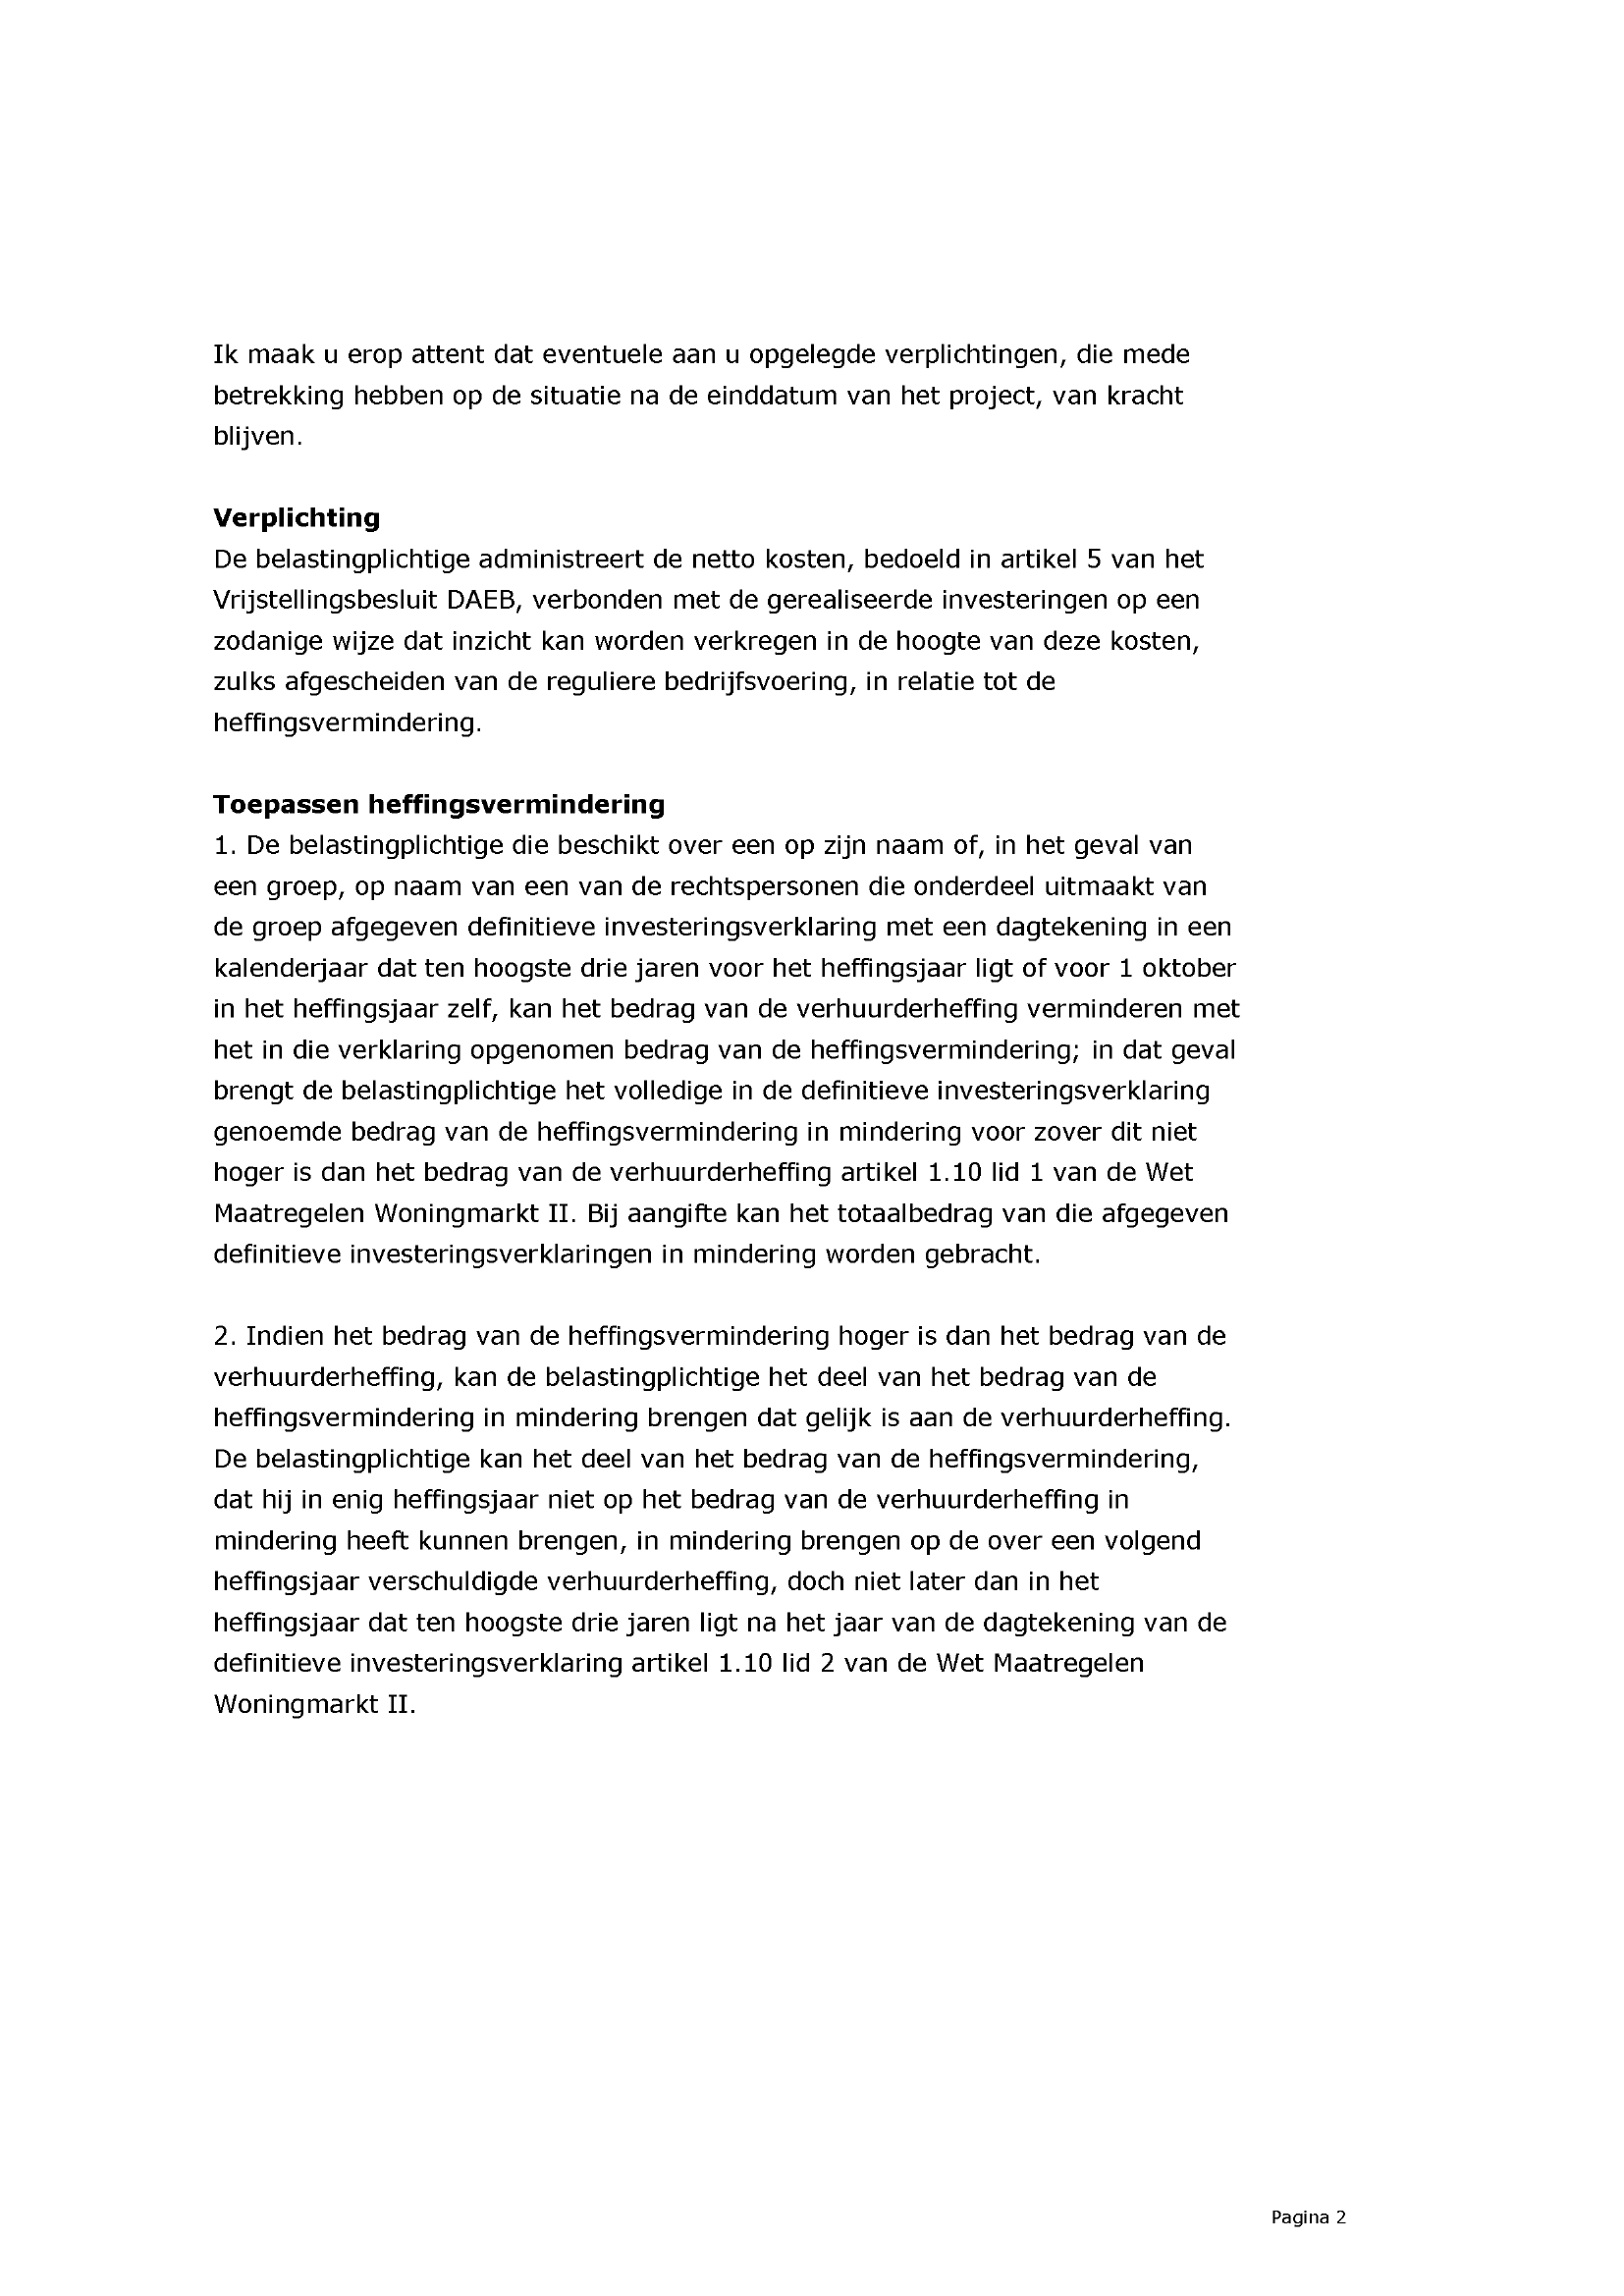

In [7]:
# show us the second page we didn't get text for
#   (notebooks treat PIL images by showing them. In practice you might .save() them instead)
chosen_image = page_images[8]
chosen_image   

In [ ]:
page_ocr_results = wetsuite.extras.ocr.easyocr( chosen_image, use_gpu=True ) 
# if GPU fails, use False,  though it'll be slower.
#  Even on GPU it'll take a minute, and despite that _some_ of that is initial loading,
#     the same on CPU will probably take a few times as long.

In [15]:
# what did that produce?
page_ocr_results

[([(213, 343), (1217, 343), (1217, 383), (213, 383)],
  'Ik maak u erop attent dat eventuele aan u opgelegde verplichtingen, die mede',
  0.7733649478286609),
 ([(214, 386), (1211, 386), (1211, 423), (214, 423)],
  'betrekking hebben op de situatie na de einddatum van het project, van kracht',
  0.9009250426350395),
 ([(216, 430), (308, 430), (308, 462), (216, 462)],
  'blijven.',
  0.6428019007528218),
 ([(215, 511), (393, 511), (393, 549), (215, 549)],
  'Verplichting',
  0.7938799971147714),
 ([(215, 551), (1233, 551), (1233, 591), (215, 591)],
  'De belastingplichtige administreert de netto kosten, bedoeld in artikel 5 van het',
  0.7423204926955493),
 ([(213, 592), (1225, 592), (1225, 632), (213, 632)],
  'Vrijstellingsbesluit DAEB, verbonden met de gerealiseerde investeringen op een',
  0.801965299925563),
 ([(212, 633), (1227, 633), (1227, 674), (212, 674)],
  'zodanige wijze dat inzicht kan worden verkregen in de hoogte van deze kosten,',
  0.7243509398531254),
 ([(213, 676), (

That's OCR results in relatively raw form, namely fragments of:
- the bounds of the box that contains this fragment of text
- the text detected inside that box
- how certain the underlying code was about the detection of this text

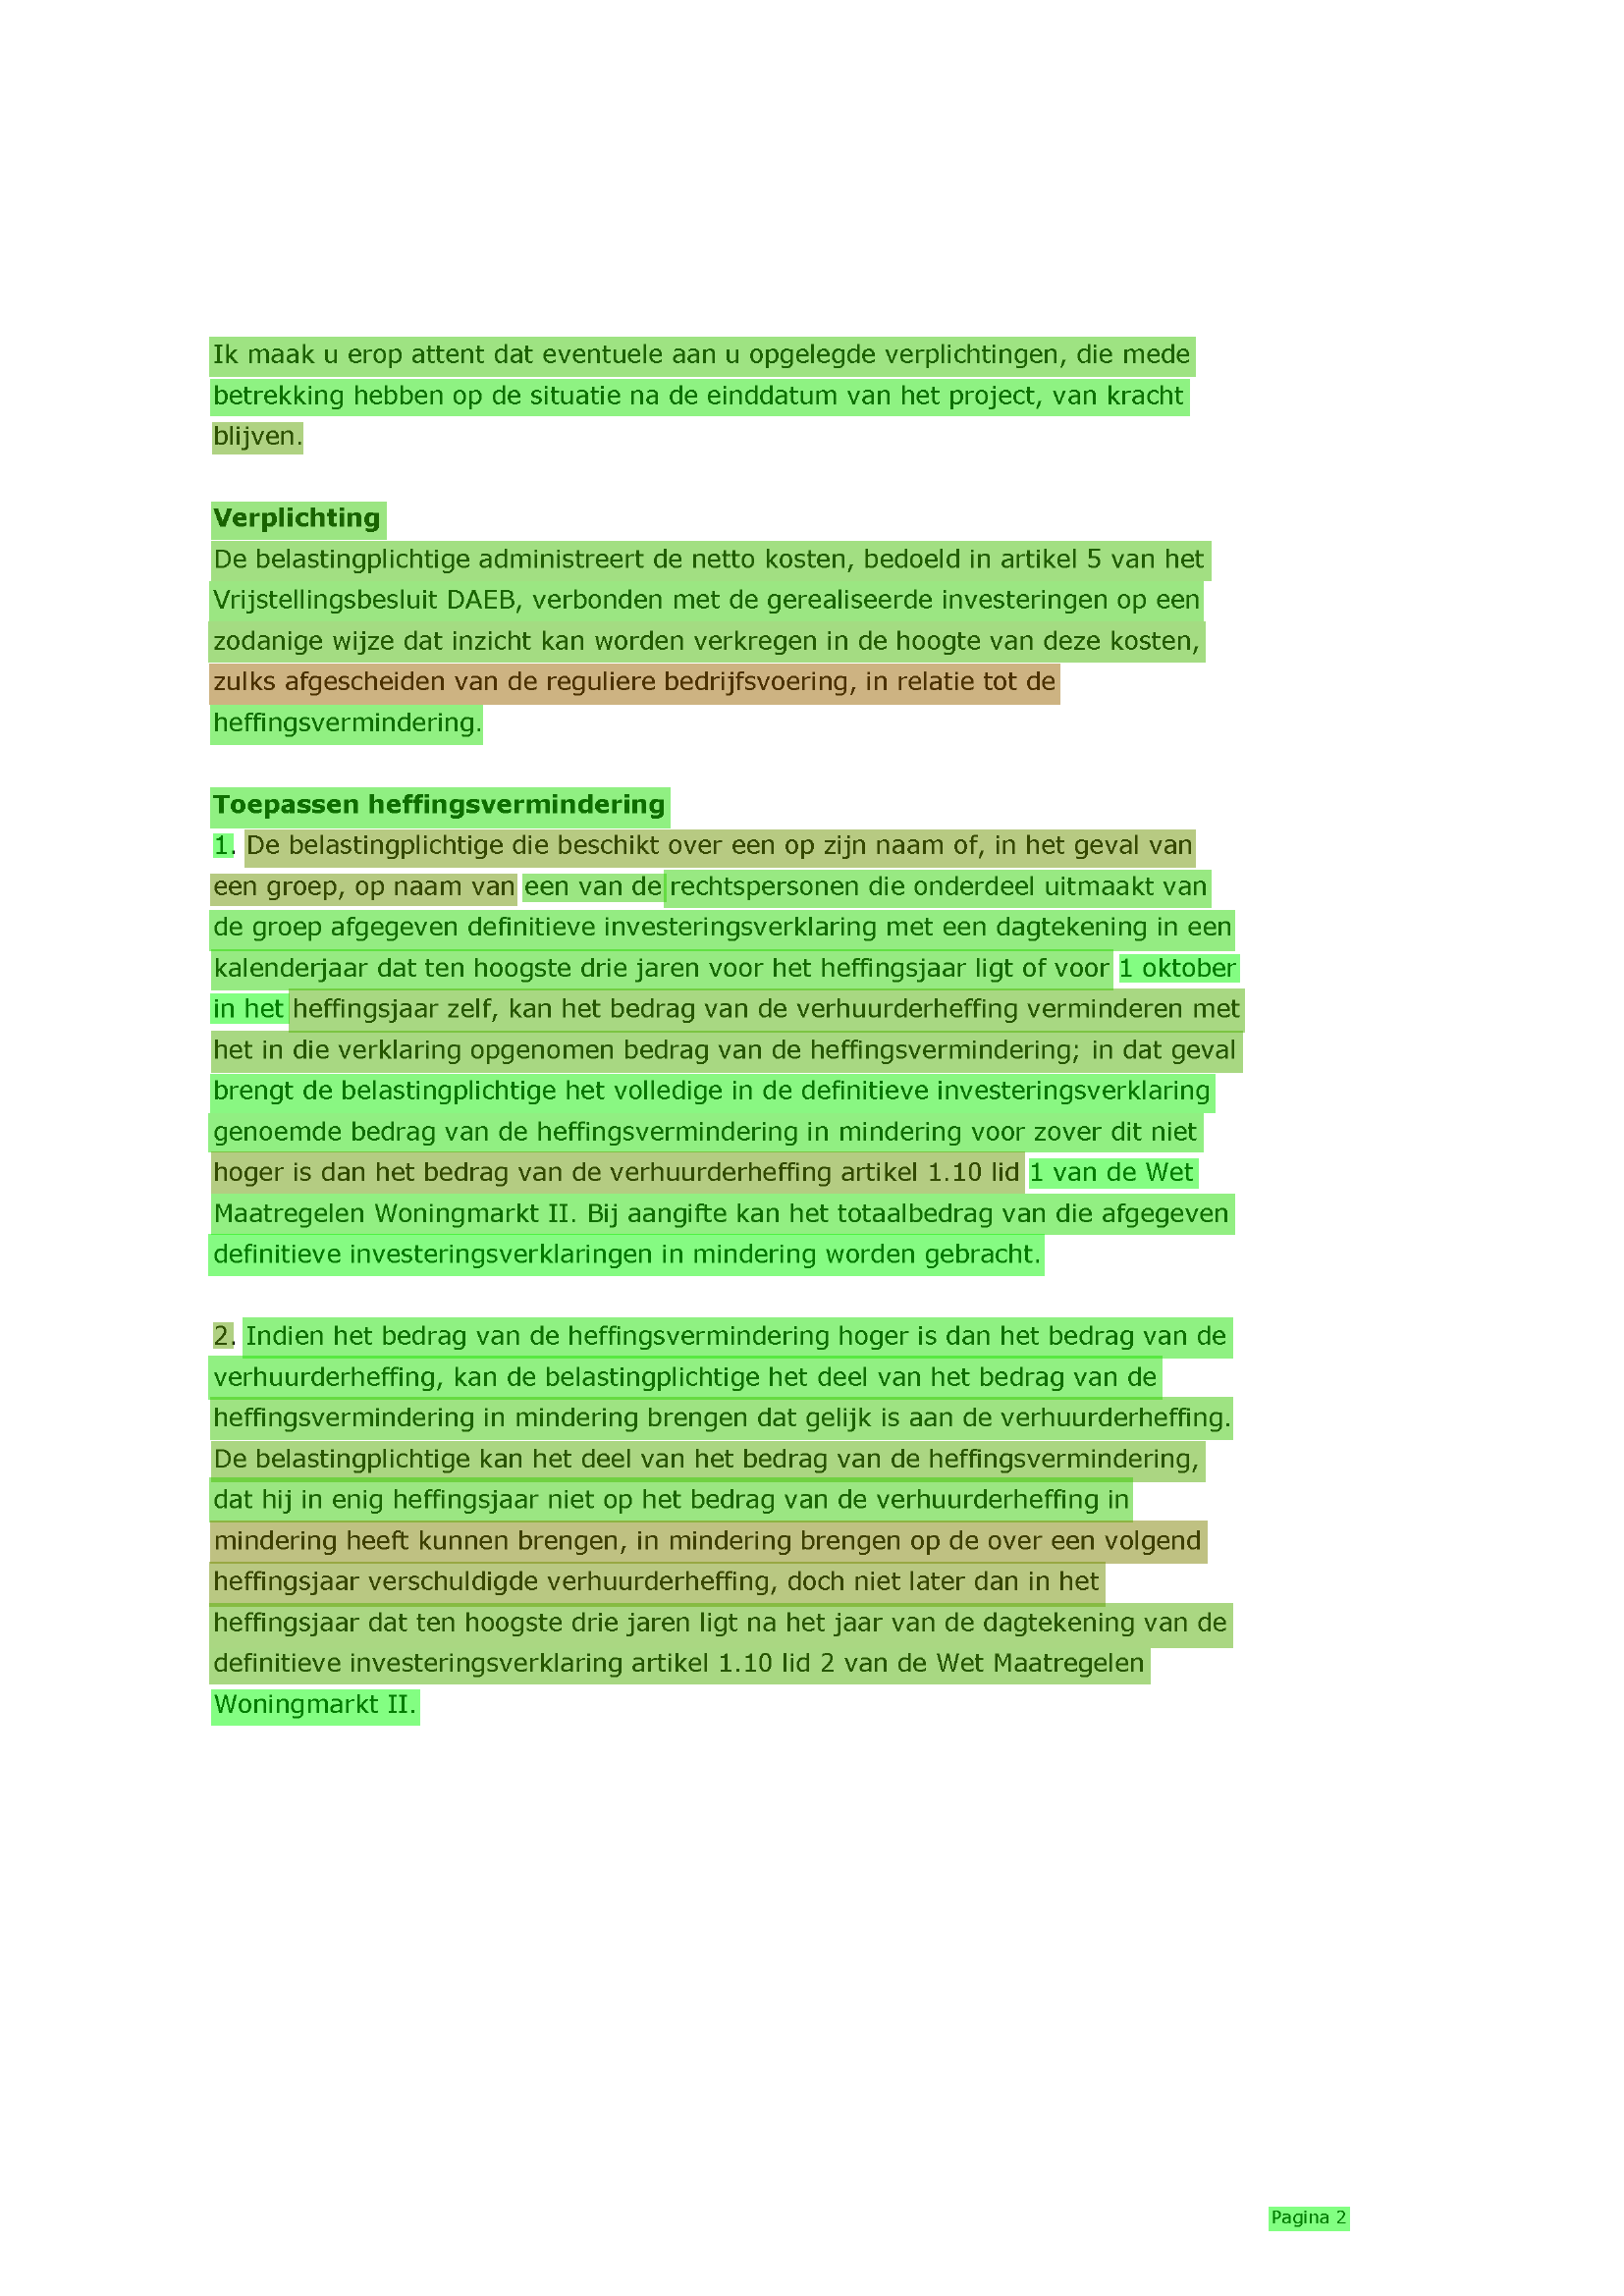

In [16]:
# As a double-check, we can draw those bounding boxes on the original image,
#   with color indicating that mentioned certainty
wetsuite.extras.ocr.easyocr_draw_eval( chosen_image, page_ocr_results ) 

In [17]:
# If you only really care about the words on the page (e.g. for bag-of-words methods),
# then you can get away with just taking out the text, e.g.
page_text = '\n'.join( list( text    for bbox, text, cert in page_ocr_results) )
print( page_text )

Ik maak u erop attent dat eventuele aan u opgelegde verplichtingen, die mede
betrekking hebben op de situatie na de einddatum van het project, van kracht
blijven.
Verplichting
De belastingplichtige administreert de netto kosten, bedoeld in artikel 5 van het
Vrijstellingsbesluit DAEB, verbonden met de gerealiseerde investeringen op een
zodanige wijze dat inzicht kan worden verkregen in de hoogte van deze kosten,
zulks afgescheiden van de reguliere bedrijfsvoering, in relatie tot de
heffingsvermindering.
Toepassen heffingsvermindering
1
De belastingplichtige die beschikt over een op zijn naam of, in het geval van
een groep, op naam van
een van de
rechtspersonen die onderdeel uitmaakt van
de groep afgegeven definitieve investeringsverklaring met een dagtekening in een
kalenderjaar dat ten hoogste drie jaren voor het heffingsjaar ligt of voor
1 oktober
in het
heffingsjaar zelf; kan het bedrag van de verhuurderheffing verminderen met
het in die verklaring opgenomen bedrag van de heffingsver

As you can see, it may fragment things acually on a single line,
it doesn't know how to separate paragraps,
and it includes words that we would say are obviously header/footer rather than the body
(which can be a feature, but for large repeated headers is also messy)

Turning this into well-flowing text takes a lot more care,
will always be a slightly creative process, 
and can be made to work better within document sets that have a consistent structure.

If you care to get into that, check out [datacollect_kansspelautoriteit.ipynb](datacollect_kansspelautoriteit.ipynb), though note it cares less about readability of the code and more about the data it produces.



### Quick and dirty variants

If you only care about the words that are in there, 
and less about nice interpretation,
then you can hand it a file and hope for the best.

In [38]:
import wetsuite.extras.pdf_text

out = wetsuite.extras.pdf_text.pdf_text_ocr( pdfbytes )
# expect this to take a minute even for smaller documents.

# there is an analogous
# wetsuite.extras.pdf2txt.pdf2txt_embedded( pdfbytes )
# and while much faster, it won't tell you that most pages are empty.